<img width="100%" align="center" src="images/pycon-tz-header.png">

# An Introduction to Plotnine
### _Visualising Data using The Grammar of Graphics_

[plotnine](https://plotnine.org) implements a concept called _The Grammar of Graphics_ and it is inspired by the R programming language package [ggplot2](https://ggplot2.tidyverse.org).

The key idea is that statistical graphics (plots) can be thought of in terms of a few categories of components and the rules (the grammar) of how the come together. In this workshop we are going to explore these components through the graphics we create.

## Import the packages we use

In [1]:
from plotnine import *
import pandas as pd
import numpy as np

## Define Some Useful Functions for Manipulating Pandas dataFrames

We want to visualise data, without the code that cleans/manipulates the data getting in the way. These functions make it easy to get subsets of the data that we will visualise. It is easier to understand what they do when we use them.

They are rather general and you may find them useful when working with other datasets.

In [2]:
def group_top(data, group, column, n):
    """
    Select the top n rows from each group in a dataframe based on a specified column
    """
    def top_n(gdf):
        return gdf.sort_values(column, ascending=False).head(n)
    return (
        data.groupby(group)
        .apply(top_n, include_groups=False)
        .reset_index()
        [data.columns]
    )

def group_bottom(data, group, column, n):
    """
    Select the bottom n rows from each group in a dataframe based on a specified column
    """
    def bottom_n(gdf):
        return gdf.sort_values(column, ascending=True).head(n)
    return (
        data.groupby(group)
        .apply(bottom_n, include_groups=False)
        .reset_index()
        [data.columns]
    )

def group_multi_top(data, group, columns, n):
    """
    Select the top n rows from each group in a dataframe for multiple columns
    """
    frames = [group_top(data, group, col, n) for col in columns]
    return (
        pd.concat(frames)
        .drop_duplicates()
        .sort_values(by=[group, *columns])
        .reset_index(drop=True)
    )

def group_multi_bottom(data, group, columns, n):
    """
    Select the bottom n rows from each group in a dataframe for multiple columns
    """
    frames = [group_bottom(data, group, col, n) for col in columns]
    return (
        pd.concat(frames)
        .drop_duplicates()
        .sort_values(by=[group, *columns])
        .reset_index(drop=True)
    )

def group_sum(data, group, columns):
    """
    Do a group sum along all specified columns
    """
    if isinstance(group, str):
        group = [group]
    else:
        group = list(group)
    return data.groupby(group)[columns].agg("sum").reset_index()

def dataframe_difference(df1, df2):
    """
    Remove all rows in df1 that are also in df2.
    """
    # Ensure the column order and names match for comparison
    common_columns = df1.columns.intersection(df2.columns)
    # Convert rows to tuples and compare them
    s1 = df1[common_columns].apply(tuple, axis=1)
    s2 = df2[common_columns].apply(tuple, axis=1)
    return df1.loc[~s1.isin(s2)].reset_index(drop=True)

## Load the main data

In [3]:
def _rename_columns(s):
    if s.endswith("population"):
        return f"{s.split()[0]}"
    return s.replace("(km²)","").strip().replace(" ", "_")

# Units
# area - km²
# density - /km²

population_data = (
    pd.read_csv("data/world_population_data.csv")
    .rename(_rename_columns, axis=1)
    .drop(columns=["rank"])
    .melt(
        id_vars=["country", "continent", "area"],
        value_vars=["2023", "2022", "2020", "2015", "2010", "2000", "1990", "1980", "1970"],
        var_name="year",
        value_name="population",
    )
    .astype({"year": int})
)

population_data.head(10)

,country,continent,area,year,population
0,India,Asia,3287590.0,2023,1428627663
1,China,Asia,9706961.0,2023,1425671352
2,United States,North America,9372610.0,2023,339996563
3,Indonesia,Asia,1904569.0,2023,277534122
4,Pakistan,Asia,881912.0,2023,240485658
5,Nigeria,Africa,923768.0,2023,223804632
6,Brazil,South America,8515767.0,2023,216422446
7,Bangladesh,Asia,147570.0,2023,172954319
8,Russia,Europe,17098242.0,2023,144444359
9,Mexico,North America,1964375.0,2023,128455567


## Define Some Useful Functions for Manipulating Our Dataset

These functions are specific to our dataset and less-likely to be useful for other.

In [4]:
def by_year(data, year):
    """
    Return a subset of the data for a given year
    """
    return data[data["year"] == year].reset_index(drop=True)

def by_continent(data, continent):
    """
    Return a subset of the data for a given continent
    """
    return data[data["continent"] == continent].reset_index(drop=True)

## Some useful constants

Our data has some large numbers, so we define some useful constants

In [5]:
thousand = 10 ** 3
million = 10 ** 6
billion = 10 ** 9

## Get Various Subsets of the data

In [6]:
population_data_2023 =  by_year(population_data, 2023)

africa_data = by_continent(population_data, "Africa")
asia_data = by_continent(population_data, "Asia")
north_america_data = by_continent(population_data, "North America")
south_america_data = by_continent(population_data, "South America")
europe_data = by_continent(population_data, "Europe")
oceania_data = by_continent(population_data, "Oceania")

continents_data = group_sum(population_data, ["continent", "year"], "population")

## First Plot


Create the simplest plot that we can

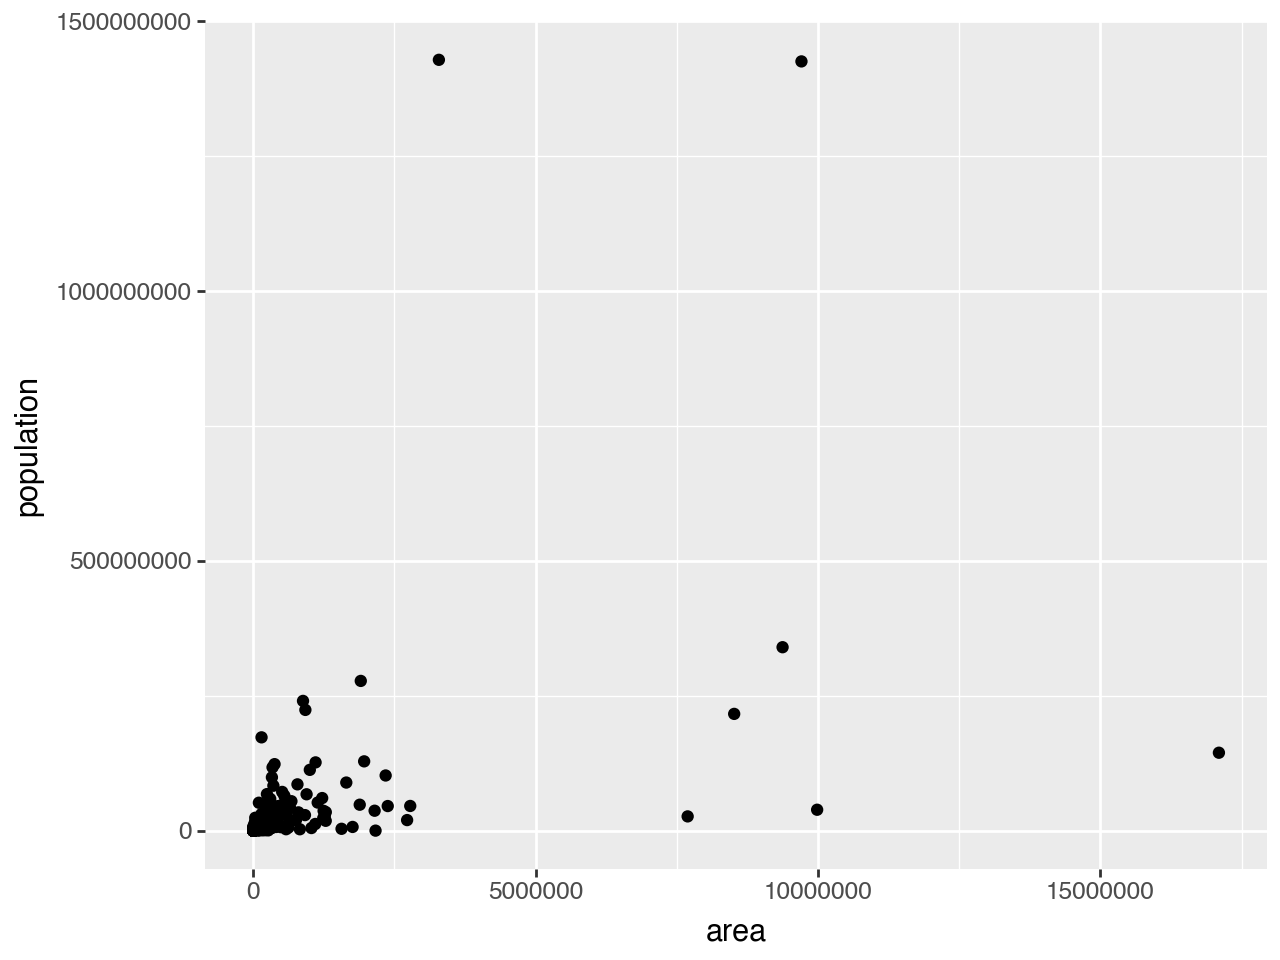

In [7]:
(
    ggplot(data=population_data_2023, mapping=aes(x="area", y="population"))
    + geom_point()
)

### Do [Exercise 1](exercises.ipynb#Exercise-1)

Actually, the simplest plot is

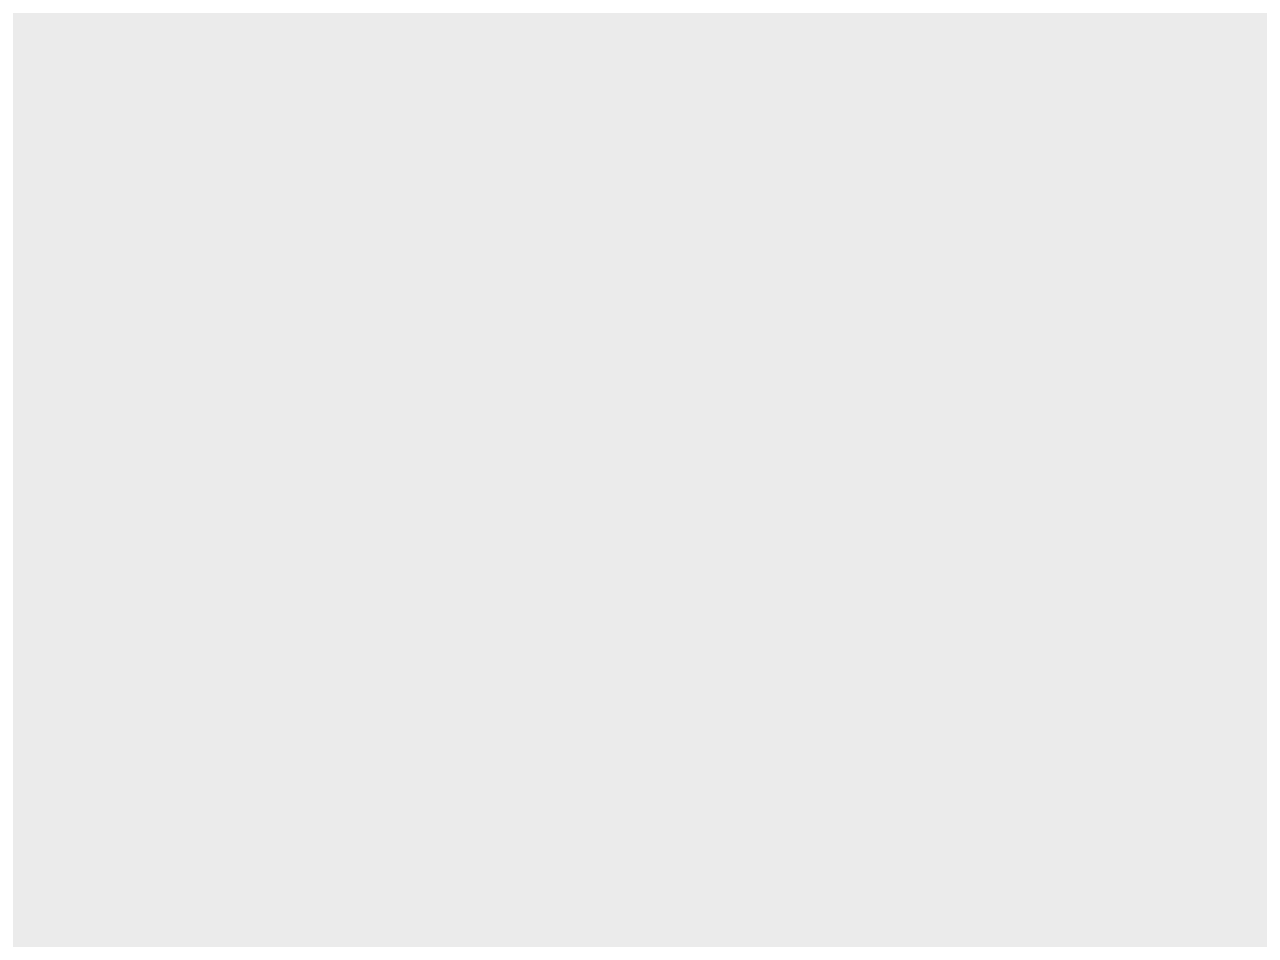

In [8]:
(
    ggplot()
)

When we add data and assign to the `x` and `y` axes, that creates the axes to give us the 2nd simplest plot

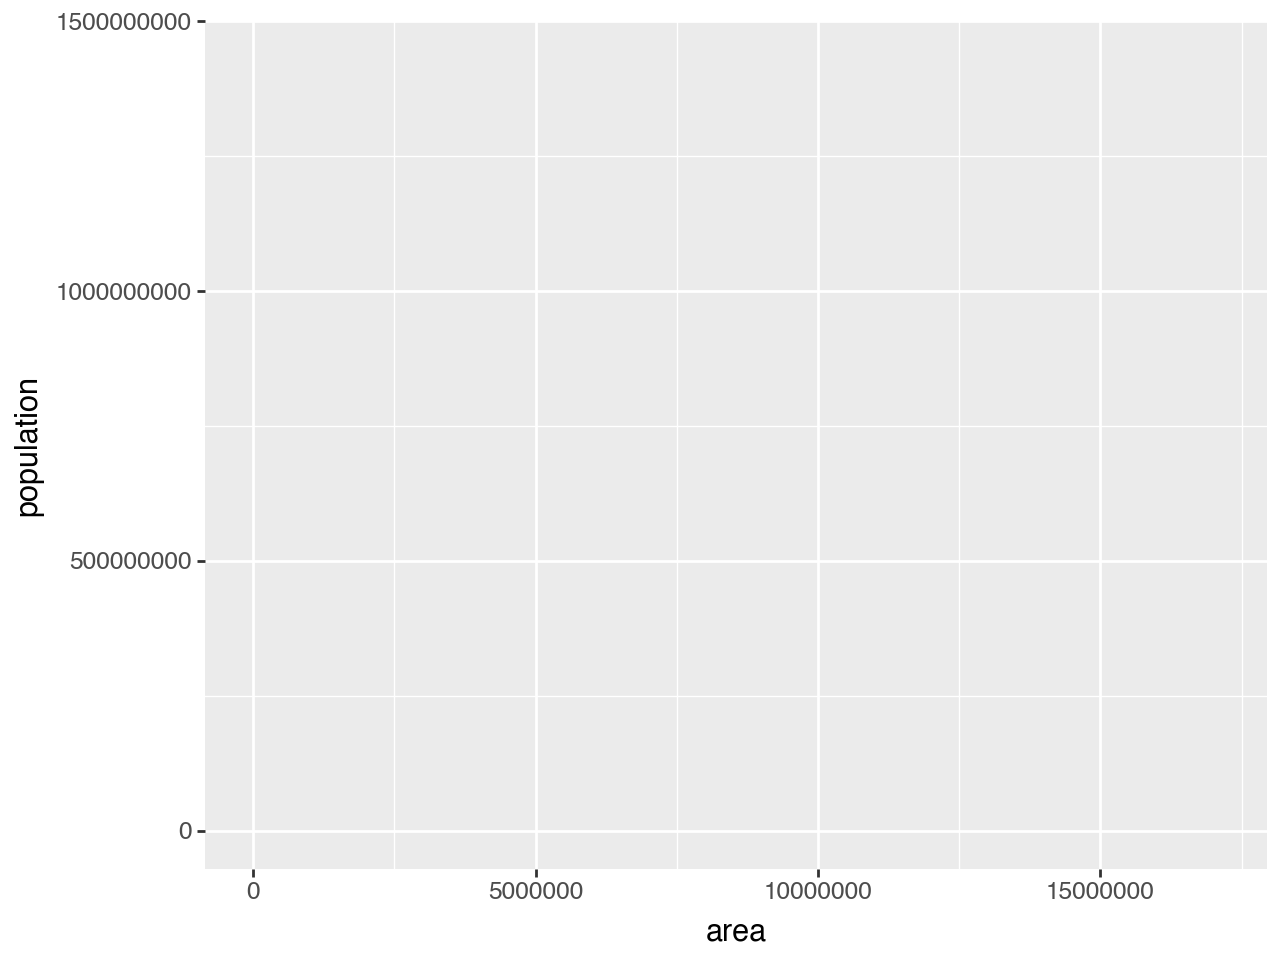

In [9]:
(
    ggplot(data=population_data_2023, mapping=aes(x="area", y="population"))
)

The `data` and `mapping` keywords can be ommitted, also, in the [aes](https://plotnine.org/reference/aes.html#plotnine.aes) call, the `x` and `y` parameters can be passed as positional parameters

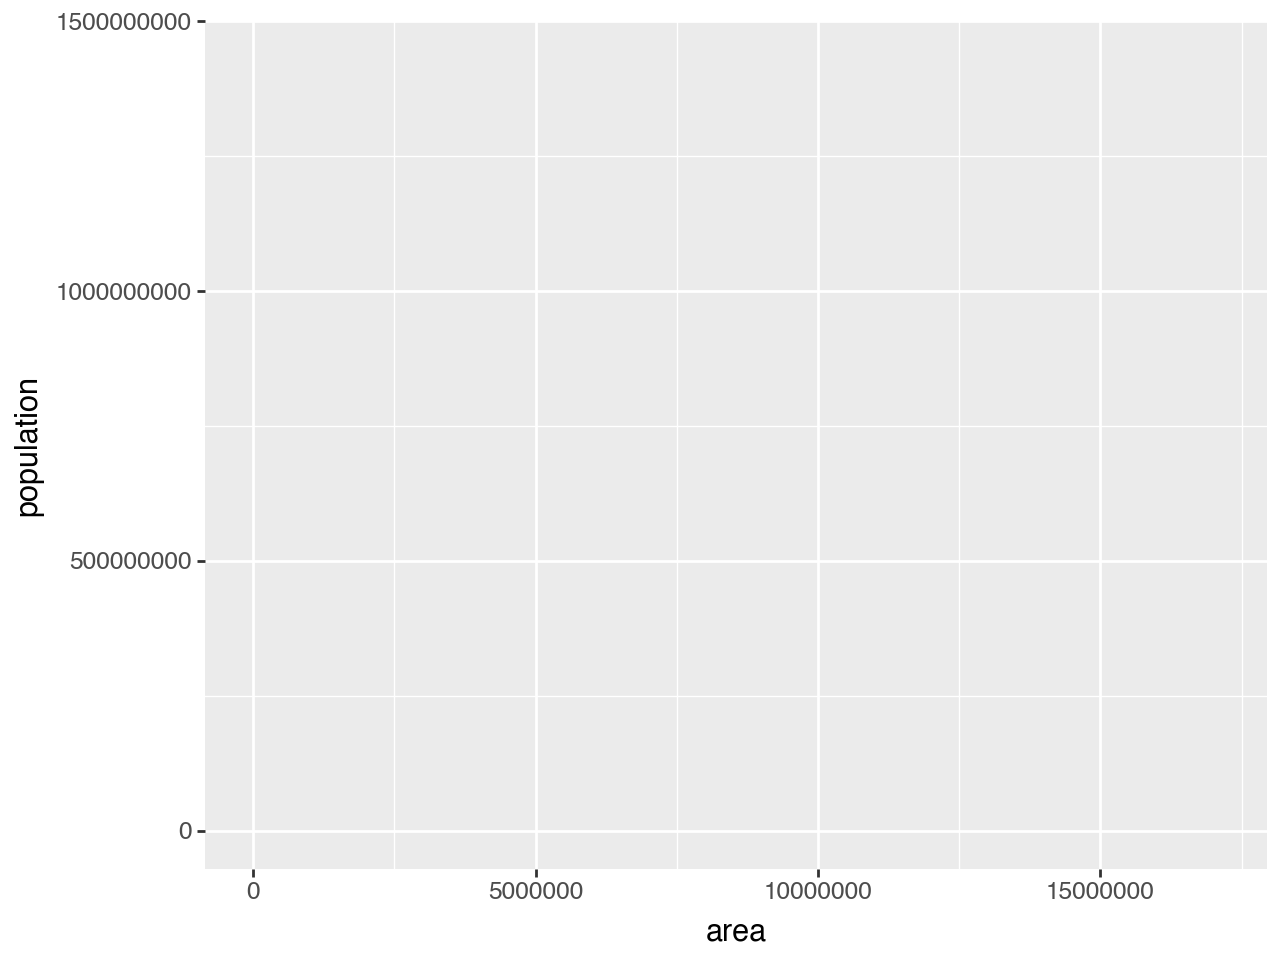

In [10]:
(
    ggplot(population_data_2023, aes("area", "population"))
)

As the values of the axes are rather large and hard to read. We reduce them by a factor, and also change the labels of the axes.

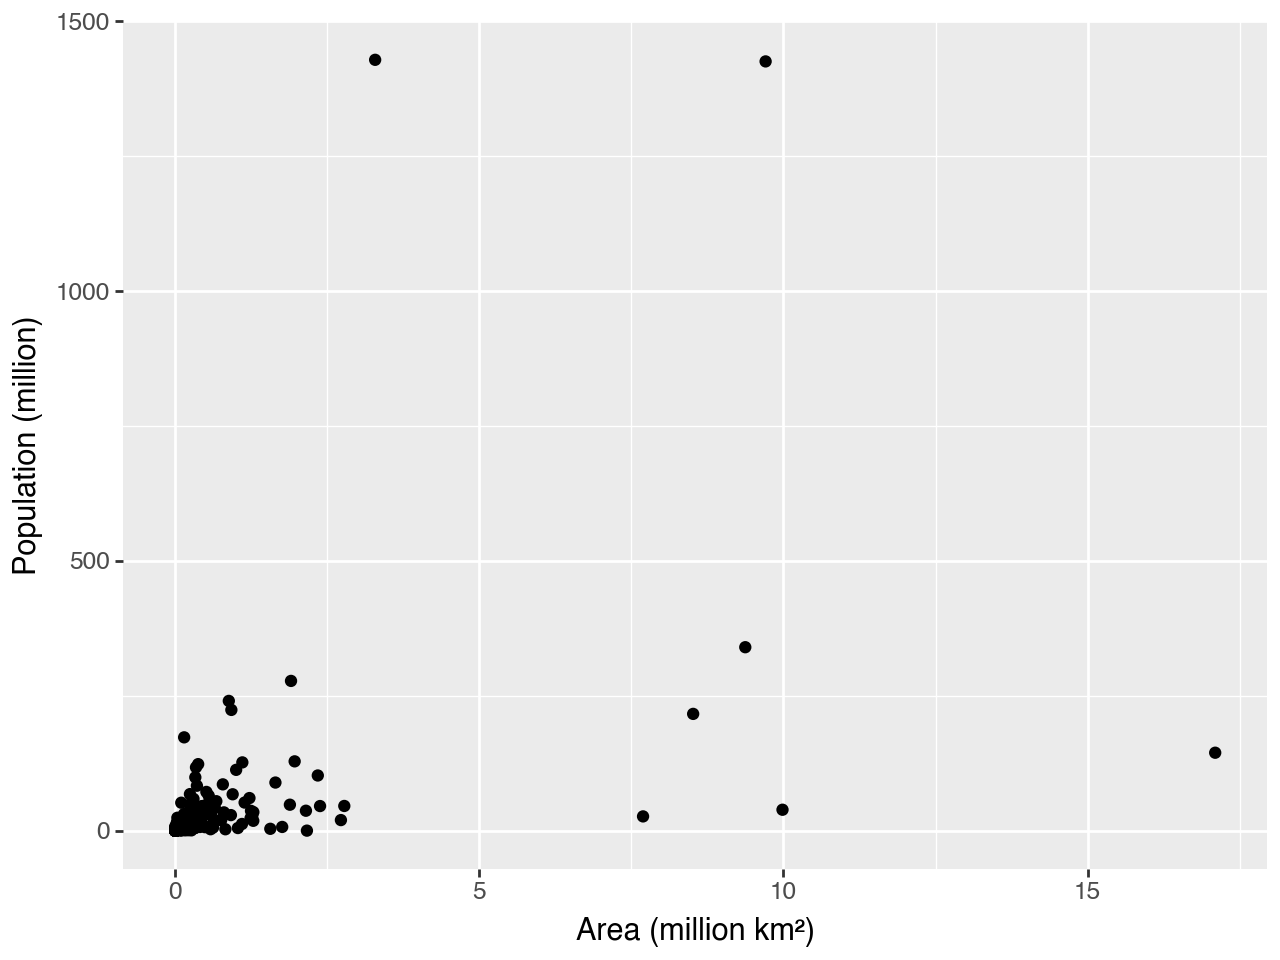

In [11]:
(
    ggplot(population_data_2023, aes("area/million", "population/million"))  # changed
    + geom_point()
    + labs(  # new
        x="Area (million km²)",
        y="Population (million)"
    )
)

Colour the points by continent

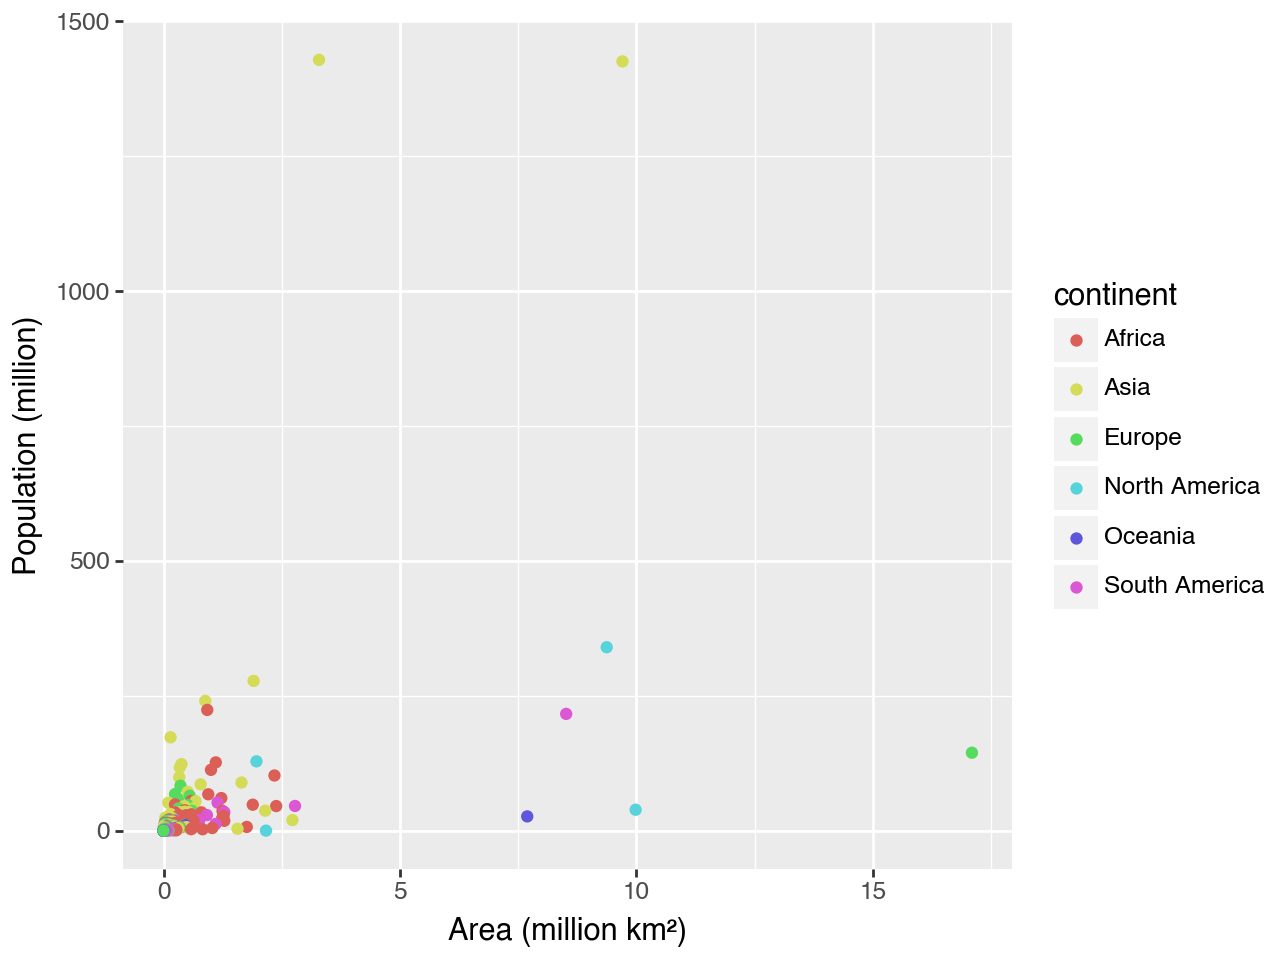

In [12]:
(
    ggplot(population_data_2023, aes("area/million", "population/million", color="continent"))  # changed
    + geom_point()
    + labs(
        x="Area (million km²)",
        y="Population (million)"
    )
)

### Do [Exercise 2](exercises.ipynb#Exercise-2)

Plot each continent on a separate panel. We call this [facetting](https://plotnine.org/reference/#facets).

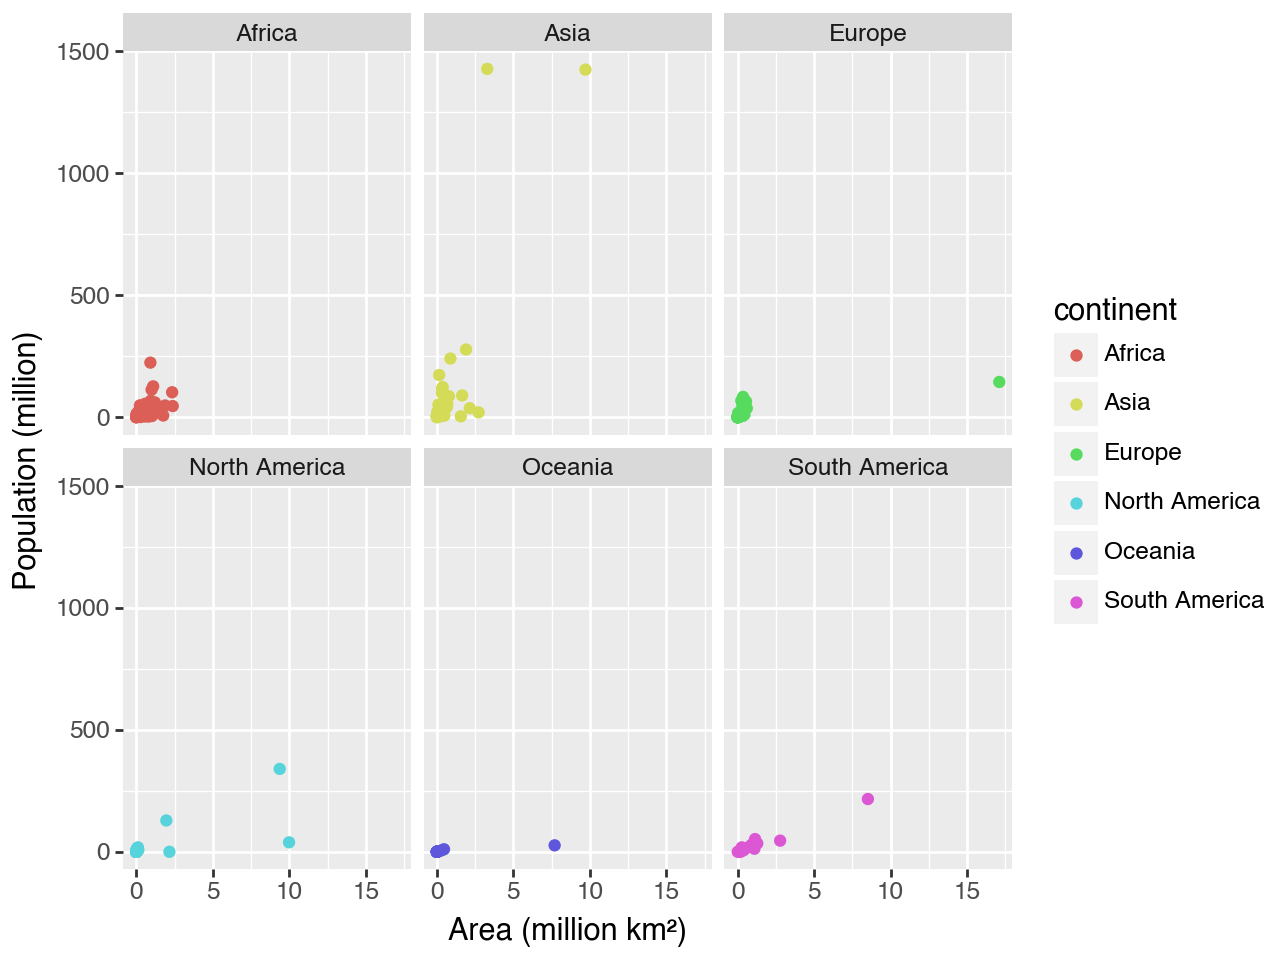

In [13]:
(
    ggplot(population_data_2023, aes("area/million", "population/million", color="continent"))
    + geom_point()
    + labs(
        x="Area (million km²)",
        y="Population (million)"
    )
    + facet_wrap("continent")  # new
)

Since each facet is well labelled, we do not need the legend. This introduces a new concept called _theming_. Theming takes care of the look and feel of everything that is not in the plot panels.

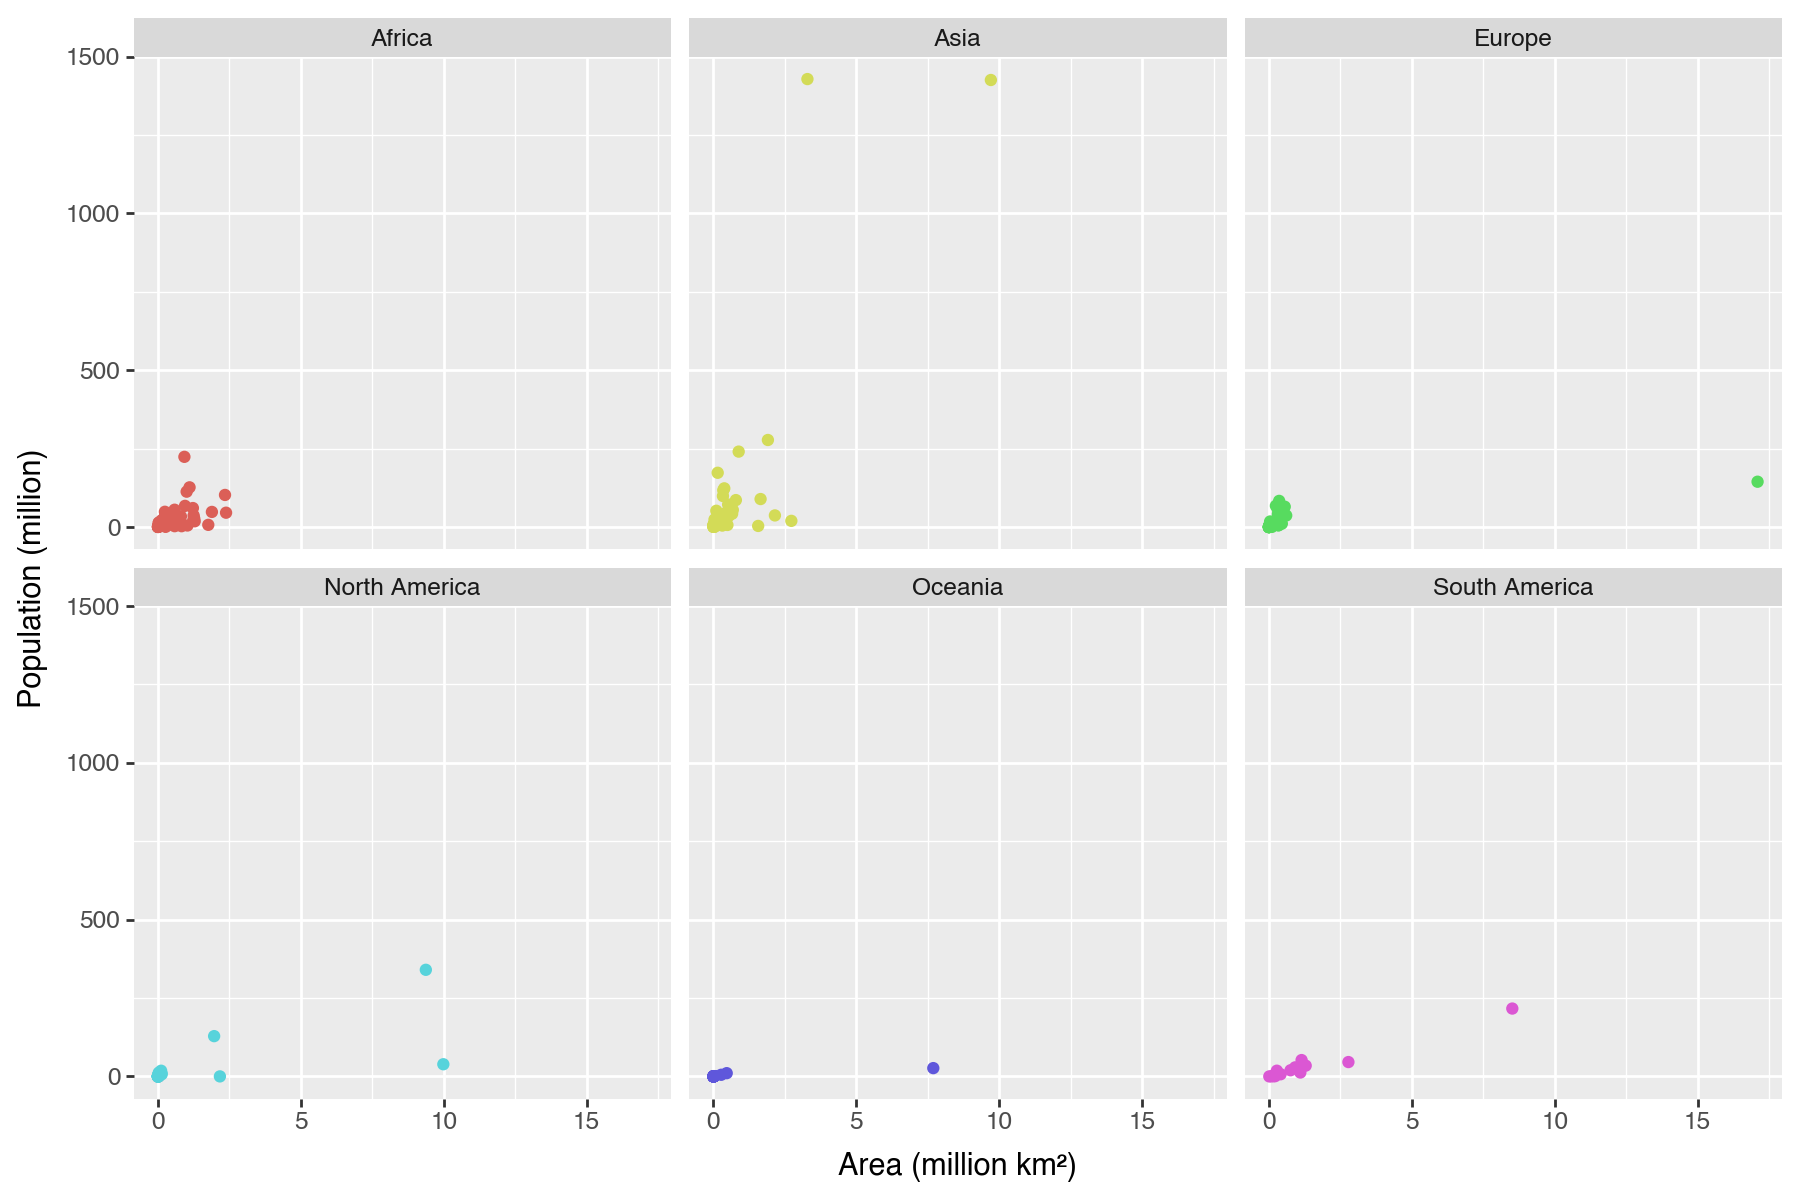

In [14]:
(
    ggplot(population_data_2023, aes("area/million", "population/million", color="continent"))
    + geom_point()
    + labs(
        x="Area (million km²)",
        y="Population (million)"
    )
    + facet_wrap("continent")
    + theme(  # new
        figure_size=(9, 6),
        legend_position="none"
    )
)

By default all panels in a column share an x-axis scale, and all those in a row share a y-axis scale. But the ranges of data for each continent vary signficantly. For example all the points in the Africa panel are squished in the bottom-left corner. So let each panel have independent axes i.e. let the scales be [free](https://plotnine.org/reference/facet_wrap.html#parameters) to vary depending on the data in the panel.

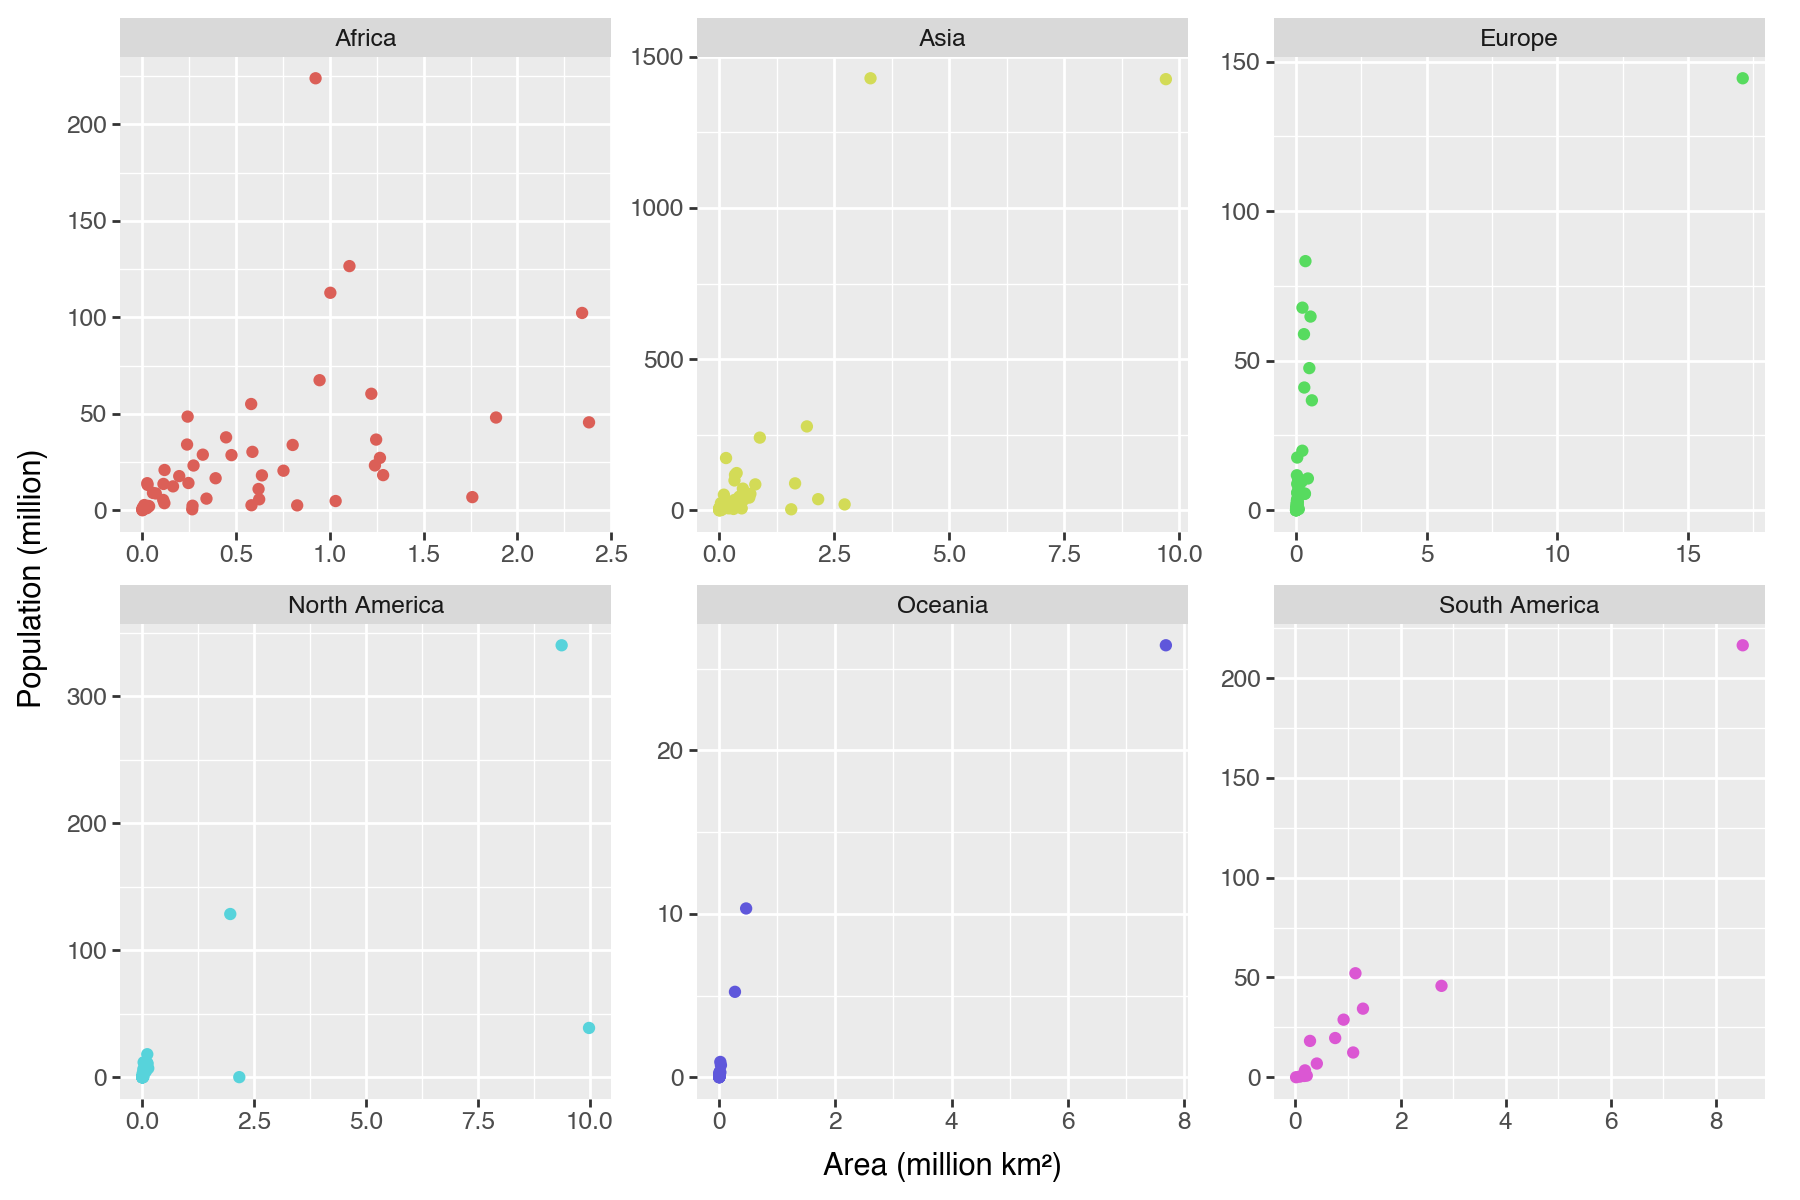

In [15]:
(
    ggplot(population_data_2023, aes("area/million", "population/million", color="continent"))
    + geom_point()
    + labs(
        x="Area (million km²)",
        y="Population (million)"
    )
    + facet_wrap("continent", scales="free")  # changed
    + theme(
        figure_size=(9, 6),
        legend_position="none"
    )
)

### Do [Exercise 3](exercises.ipynb#Exercise-3)

Even with that, we still have wide variation between points in a panel. But it is restricted to a few outliers in each panel. We want to label these points.

With one of our previously defined helpful functions, we get a dataset of the high value outliers along both axes.

In [16]:
high_outliers = group_multi_top(population_data_2023, "continent", ["population", "area"], 2)
high_outliers

,country,continent,area,year,population
0,Algeria,Africa,2381741.0,2023,45606480
1,DR Congo,Africa,2344858.0,2023,102262808
2,Ethiopia,Africa,1104300.0,2023,126527060
3,Nigeria,Africa,923768.0,2023,223804632
4,China,Asia,9706961.0,2023,1425671352
5,India,Asia,3287590.0,2023,1428627663
6,Ukraine,Europe,603500.0,2023,36744634
7,Germany,Europe,357114.0,2023,83294633
8,Russia,Europe,17098242.0,2023,144444359
9,Canada,North America,9984670.0,2023,38781291


Using this smaller dataset, we add a layer of text to label the "interesting" points. We also turn on text repelling to place the label away from the points. See [adjust_text](https://adjusttext.readthedocs.io/en/latest/) for more.

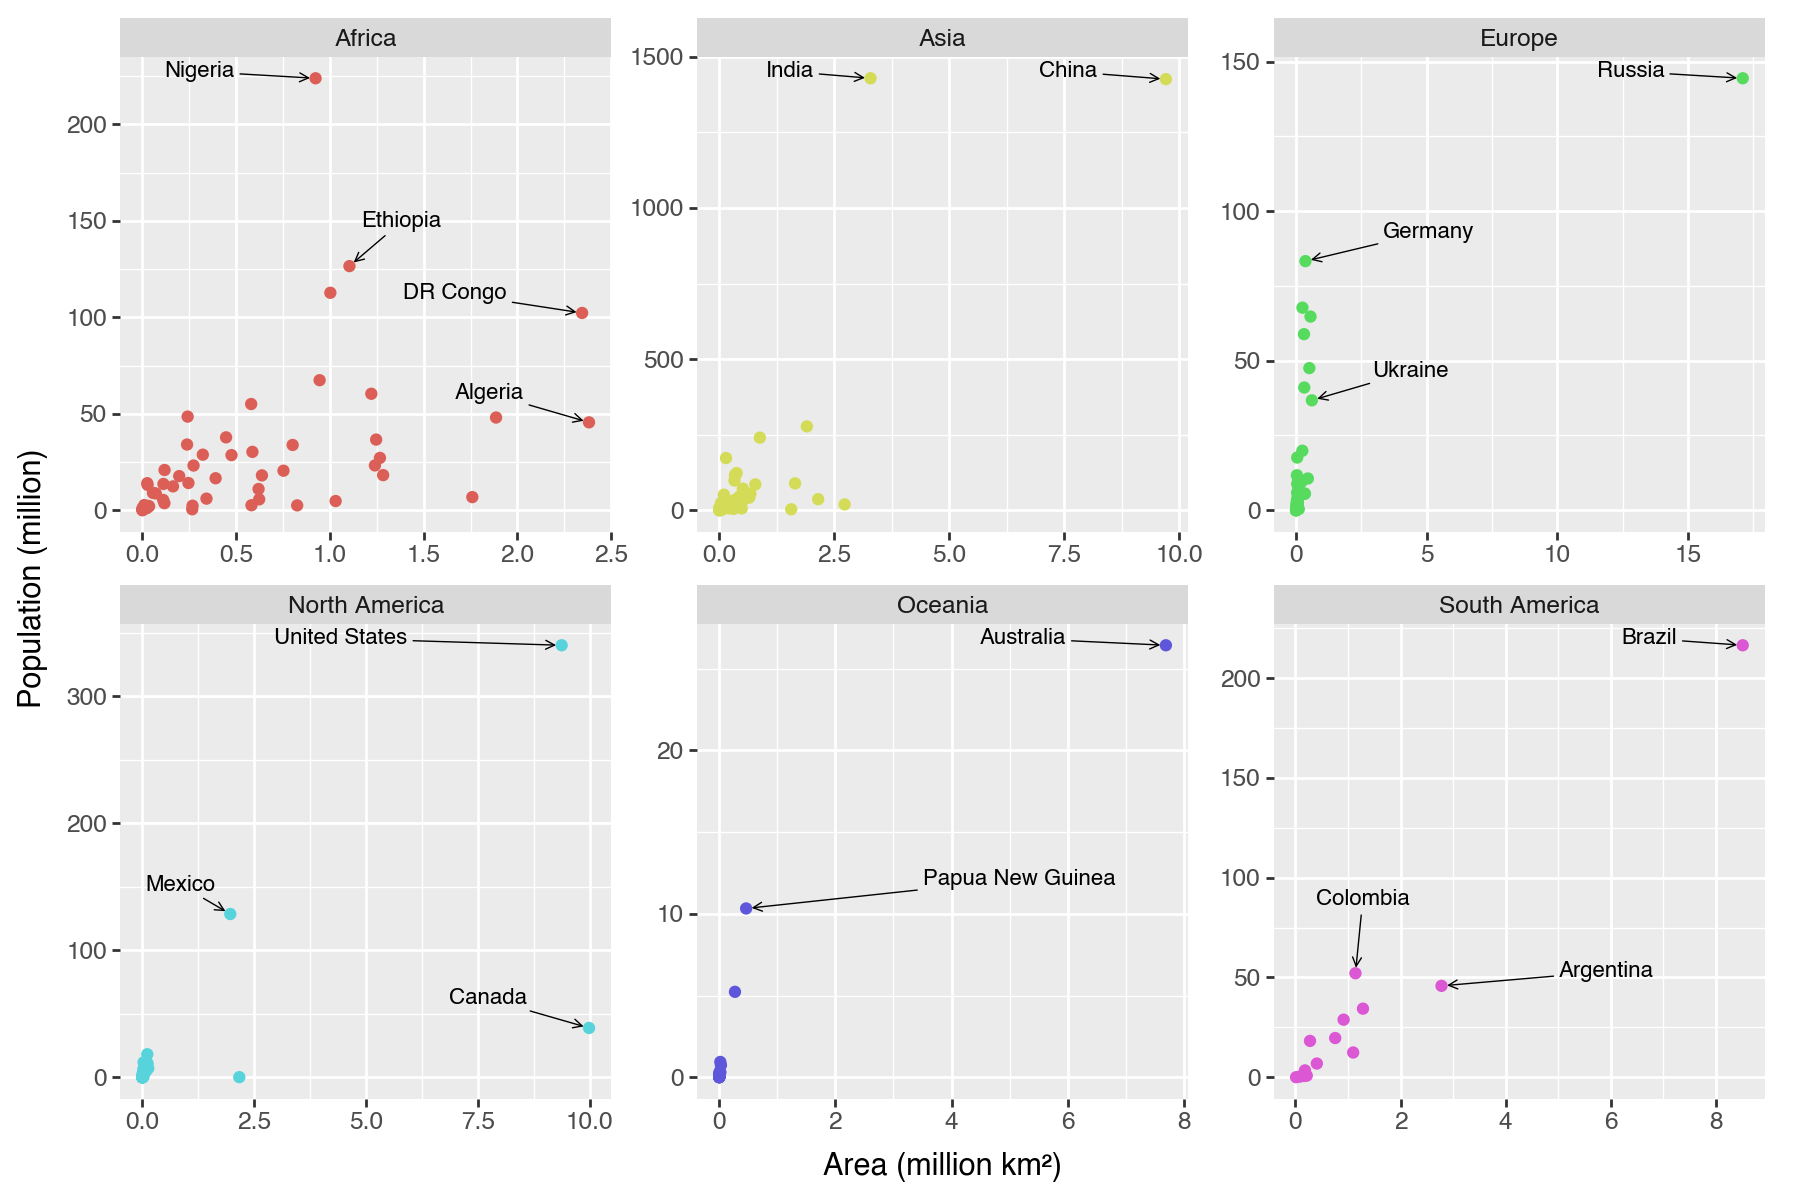

In [17]:
(
    ggplot(population_data_2023, aes("area/million", "population/million", color="continent"))
    + geom_point()
    + geom_text(  # new
        aes(label="country"),  
        high_outliers,
        color="black",
        va="bottom",
        size=8,
        adjust_text={"expand": (2, 2)}  # turnon repelling
    )
    + labs(
        x="Area (million km²)",
        y="Population (million)"
    )
    + facet_wrap("continent", scales="free")
    + theme(
        figure_size=(9, 6),
        legend_position="none"
    )
)

We also add a linear model (regression line) through the points.

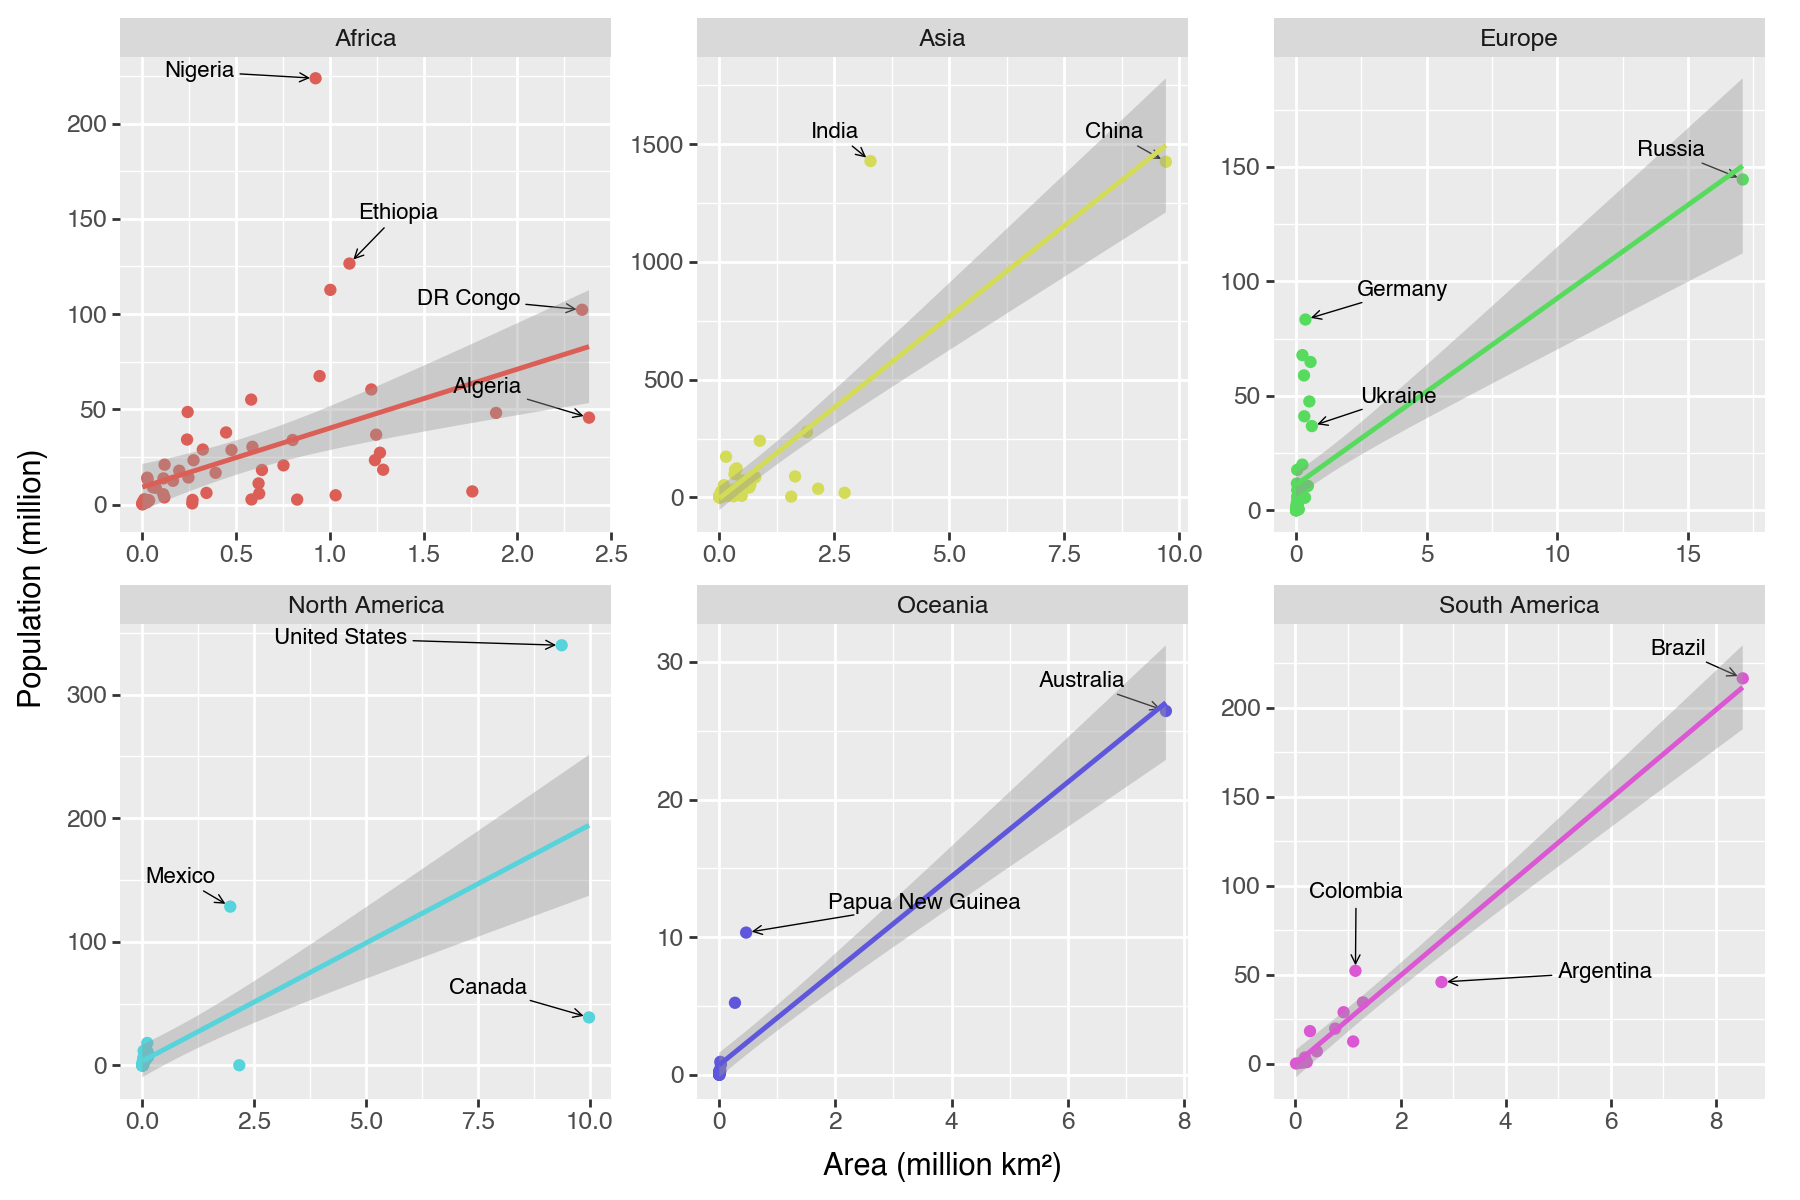

In [18]:
(
    ggplot(population_data_2023, aes("area/million", "population/million", color="continent"))
    + geom_point()
    + stat_smooth(method="lm")  # new
    + geom_text(
        aes(label="country"),
        high_outliers,
        color="black",
        va="bottom",
        size=8,
        adjust_text={"expand": (2, 2)}
    )
    + labs(
        x="Area (million km²)",
        y="Population (million)"
    )
    + facet_wrap("continent", scales="free")
    + theme(
        figure_size=(9, 6),
        legend_position="none"
    )
)

### Customising / Theming

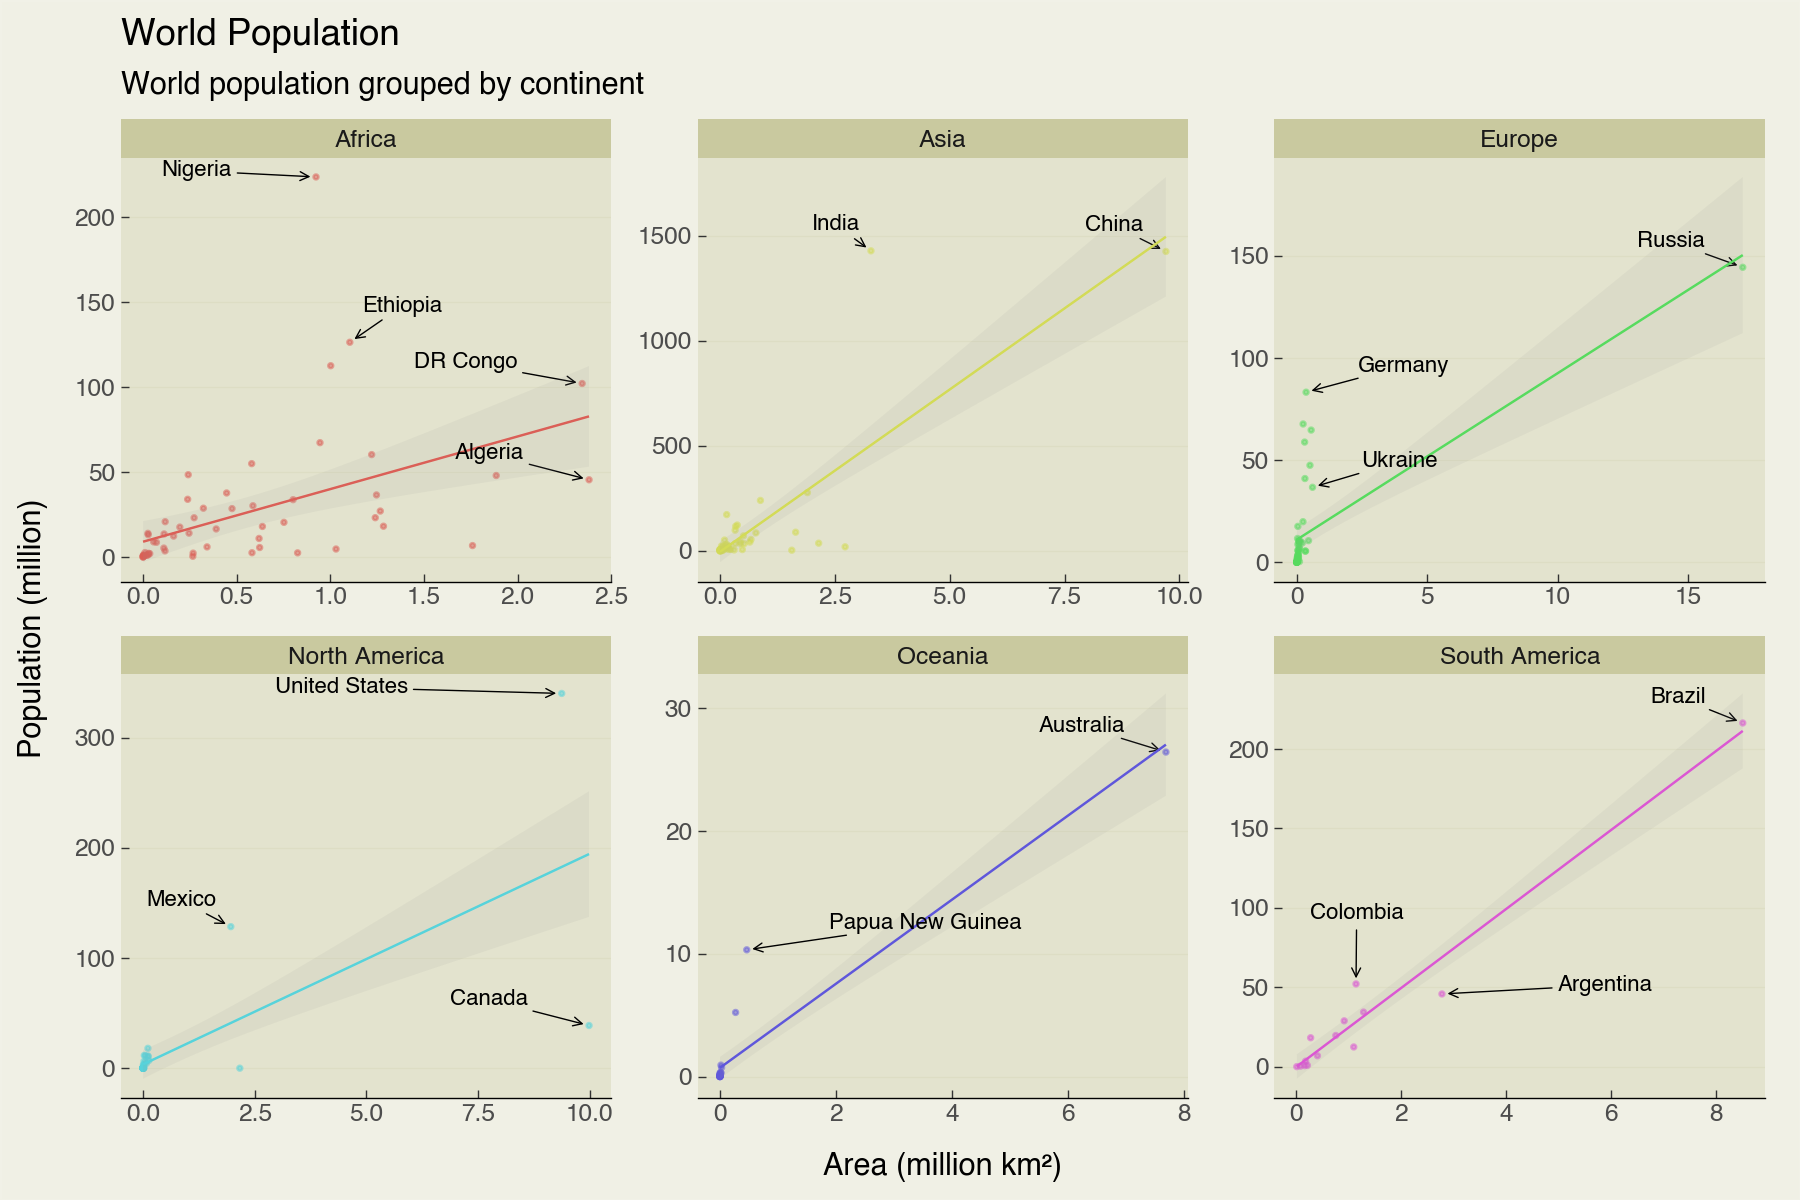

In [19]:
bg_color = "#707000"
(
    ggplot(population_data_2023, aes("area/million", "population/million", color="continent"))
    + geom_point(size=0.5, alpha=0.5) # changed
    + stat_smooth(method="lm", size=0.5, alpha=0.1)  # changed
    + geom_text(
        aes(label="country"),
        high_outliers,
        color="black",
        va="bottom",
        size=8,
        adjust_text={"expand": (2, 2)}
    )
    + labs(
        x="Area (million km²)",
        y="Population (million)",
        title="World Population",  # new
        subtitle="World population grouped by continent",  # new
    )
    + facet_wrap("continent", scales="free")
    + theme(
        figure_size=(9, 6),
        legend_position="none",
        axis_line_x=element_line(size=0.5),  # new
        axis_ticks_major=element_line(size=0.5),  # new
        axis_ticks_length_major=-3,  # new
        panel_grid=element_blank(),  # new
        panel_grid_major_y=element_line(color=bg_color, size=0.5, alpha=0.05),  # new
        plot_background=element_rect(fill=bg_color, alpha=0.1),  # new
        panel_background=element_rect(fill=bg_color, alpha=0.1),  # new
        strip_background=element_rect(fill=bg_color, alpha=0.3),  # new
    )
)

### Do [Exercise 4](exercises.ipynb#Exercise-4)

The confidence interval around the linear model is funnel shaped. So we suspect that the relationship between the two variables is not linear.
We also have disproportionately large values for both values. This is a clue to maybe transform the values, so we will log transform both varaibles to create
a [log-log plot](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot).

And because our plot is now non-linear, we make the minor ticks visible.

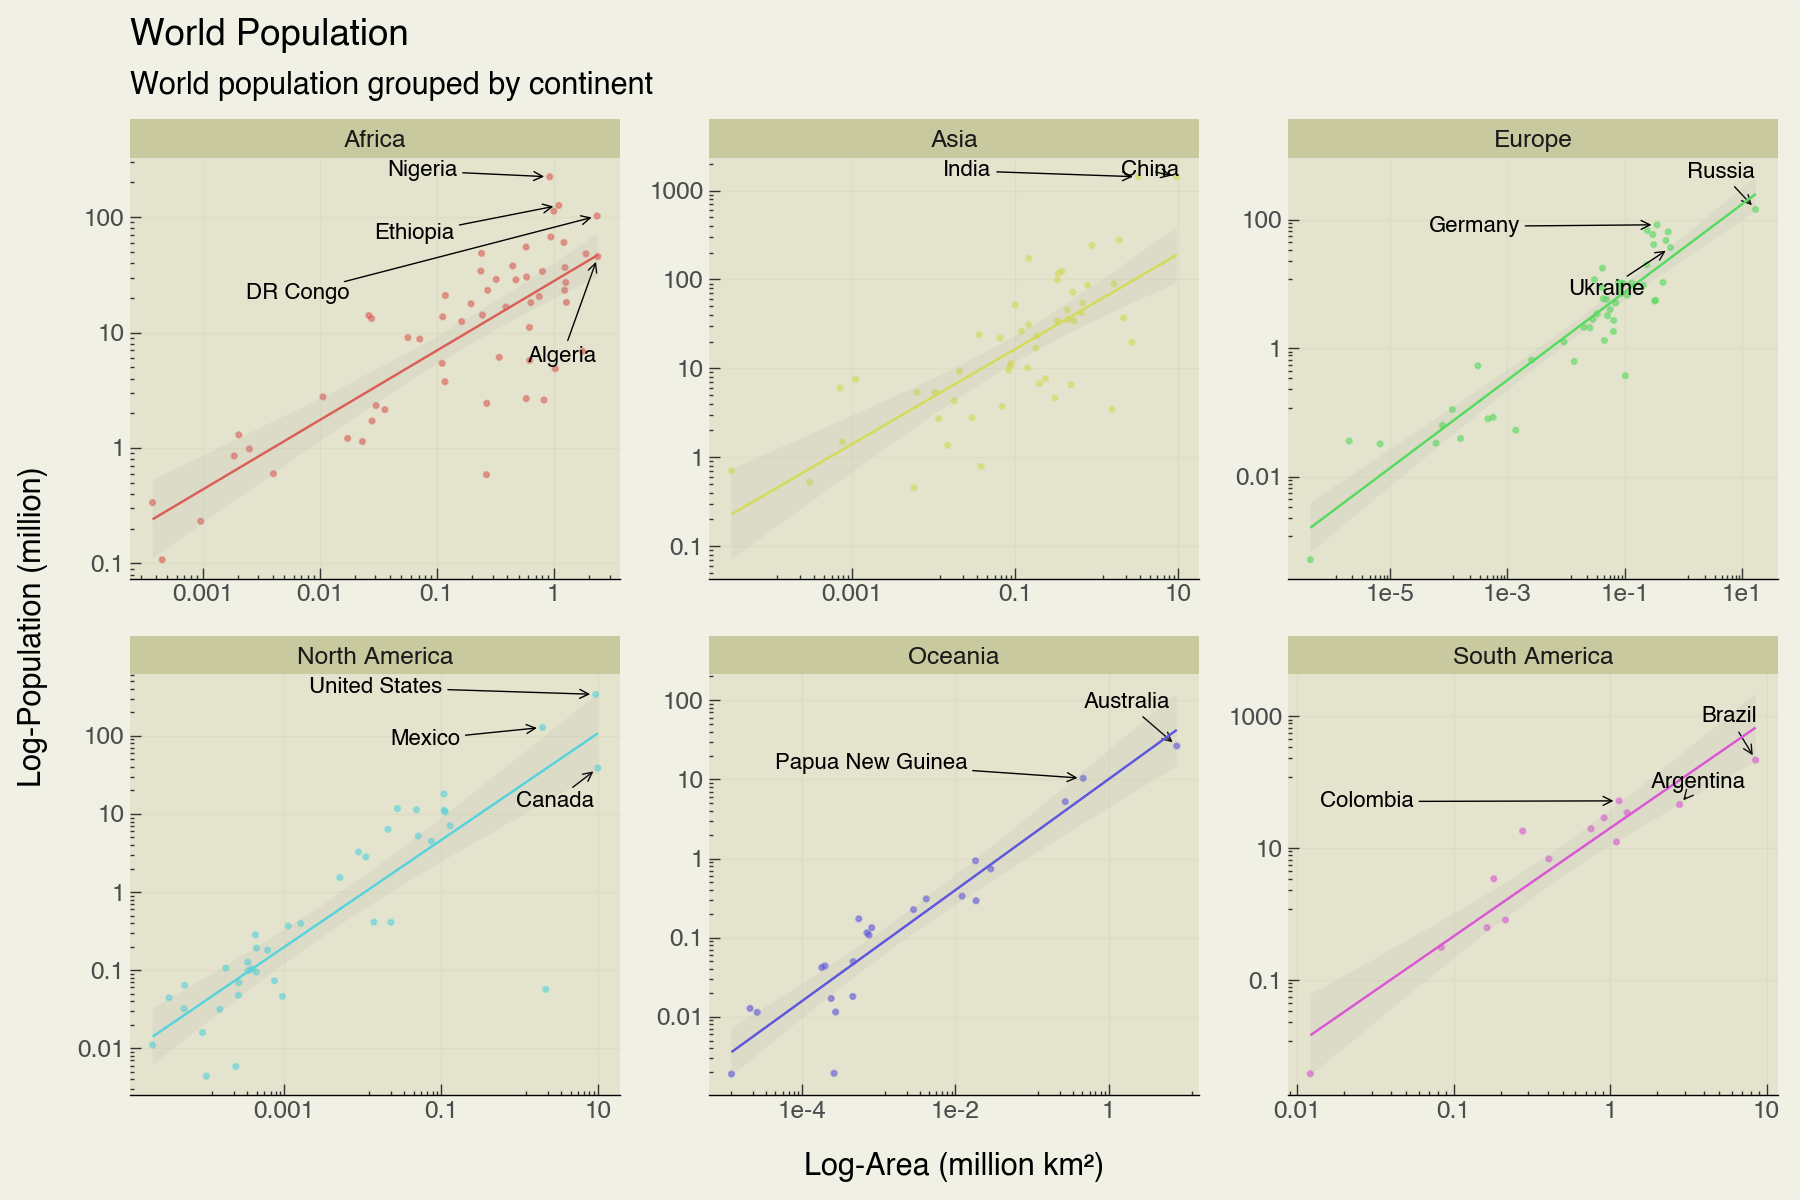

In [20]:
bg_color = "#707000"

(
    ggplot(population_data_2023, aes("area/million", "population/million", color="continent"))
    + geom_point(size=0.5, alpha=0.5)
    + stat_smooth(method="lm", size=0.5, alpha=0.1)
    + geom_text(
        aes(label="country"),
        high_outliers,
        color="black",
        va="bottom",
        size=8,
        adjust_text={"expand": (2, 2)}
    )
    + labs(
        x="Log-Area (million km²)",  # changed
        y="Log-Population (million)",  # changed
        title="World Population",
        subtitle="World population grouped by continent",
    )
    + facet_wrap("continent", scales="free")
    + scale_y_log10()  # new
    + scale_x_log10()  # new
    + theme(
        figure_size=(9, 6),
        legend_position="none",
        axis_line_x=element_line(size=0.5),
        axis_ticks=element_line(size=0.5),
        axis_ticks_length_major=-4,  # new
        axis_ticks_length_minor=-1.5, # new
        panel_grid=element_blank(),
        panel_grid_major=element_line(color=bg_color, size=0.5, alpha=0.05),
        plot_background=element_rect(fill=bg_color, alpha=0.1),
        panel_background=element_rect(fill=bg_color, alpha=0.1),
        strip_background=element_rect(fill=bg_color, alpha=0.3),
    )
)

### Do [Exercise 5](exercises.ipynb#Exercise-5)

#### Recap

What we have covered

- [ggplot](https://plotnine.org/reference/ggplot.html#plotnine.ggplot)
- [aes](https://plotnine.org/reference/aes.html#plotnine.aes)
- [geoms](https://plotnine.org/reference/#geoms)
- [stats](https://plotnine.org/reference/#stats)
- [scales](https://plotnine.org/reference/#scales)
- [facets](https://plotnine.org/reference/#facets)
- [themes](https://plotnine.org/reference/#themes) 

What we have not covered
- [positions](https://plotnine.org/reference/#positions)
- [coords](https://plotnine.org/reference/#coords)
- [guides](https://plotnine.org/reference/#scale-guides)

### Do [Exercise 6](exercises.ipynb#Exercise-6)